## Fastiai Chapter 2 Deployment Write-up

### Importing needed dependencies
- Simply use dependencies in fastbook to easily and quickly import all libraries and modules needed

In [1]:
from fastbook import *
from fastai.vision.widgets import *

### Grabbing the images using Microsoft Azure
- In order to get your API_SEARCH_KEY, you need to first make a free account in Microsoft Azure
- Then, you need to head to https://portal.azure.com/#create/microsoft.bingsearch to create a Bing search resource
    - Resource group and instance name doesn't really matter, I just used Fastai and Chapter 2 respectively for the sake of organization
    - I left the tags blank as well
    - Then review + create
- After deployment, click on "Go to resource" > "Keys and Endpoint"
    - Use one of the two keys you are given
- Voila

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '3fb150a318e3420daf9d0f3ca00e876c')
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl') #this gets all the URLs returned by the bing search and placing it in the ims list
len(ims)

150

### Testing images
- To see if you actually have the images, you can grab 1 URL from the 150 you have
- Set your destination path (e.g. in this case images/grizzly.jpg)
- download_url(image, path)
- Then, open the image and resize it to 128px by 128px and show it in the notebook

In [8]:
#when actually doing work, do not run this line, this will replace your 150 list with just this image
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

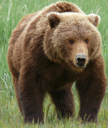

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

### Collecting and Storing the Data
- The bulk of the code is basically in the for loop which:
    1. Starts with making the destination path/directory for downloading the images
    2. Then results lists grabs all the images associated with the bear using search_images_bing with your api key
    3. Then downloads the images to the desination path with the names of each image being their URL
    4. This process is repeated for however many bear_types there are, in this case 3
- This procedure might take a few minutes as you have 150 images for each bear and you're downloading all of them locally into 3 separate directories
- You can double-check your image paths either with the second block or just going to the directory either in your terminal or vscode sidebar

In [3]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [4]:
fns = get_image_files(path)
fns

(#428) [Path('bears/black/06c39bf6-319f-46db-9899-ccf62f57d981.jpg'),Path('bears/black/08d63f48-57fc-400d-9006-ee033b9a757c.jpg'),Path('bears/black/09b48114-df91-4c0d-b56a-7d6660752db8.jpg'),Path('bears/black/0c4b7ef7-f887-4b03-961b-9ea7541dedfd.jpg'),Path('bears/black/0d2b26e4-962b-4817-a8c4-f9494a5ea9cb.jpg'),Path('bears/black/10d7fdd7-4fd7-43a7-80f6-c778dc20d042.jpg'),Path('bears/black/12b0fec4-0682-4357-995a-d46b31fc315f.jpg'),Path('bears/black/1373f871-4342-4d4a-8ea7-cad3c742a905.jpg'),Path('bears/black/1529316a-904b-43e1-a9e8-3dcaf0dfeec7.jpg'),Path('bears/black/15a95ffa-0dff-4104-a149-de9d2e7c407a.jpg')...]

### Verifying Data
- Now that you have your data, you should verify that they are valid
- Sometimes data may be invalid/useless so we should get rid of them before doing any ML work by unlinking them
- Following code checks if the images are corrupt or if we cannot open them for whatever reason, if they are, we unlink them
- Note: it seems that if you run verify_images again, the failed images are still there in failed, but not in your directory anymore
- Use ??object to get documentation on a function or object that you don't know

In [13]:
failed = verify_images(fns)
failed

(#17) [Path('bears/black/7909da31-be95-4ec3-8eaf-b16f4aa519c1.jpg'),Path('bears/black/a6c76d3e-e384-4da2-91b4-e9b252fc442f.jpg'),Path('bears/grizzly/4b639073-959a-40e5-bc08-7f9a9c44aeff.JPG'),Path('bears/grizzly/51f3d4e2-4438-4638-a682-ad8c465b4aad.jpg'),Path('bears/grizzly/72dfd813-ea43-4385-9b98-0a0c856eaa10.jpg'),Path('bears/grizzly/9b43b8fe-a2f5-43c8-8754-612d3ca99a58.jpg'),Path('bears/grizzly/c7b51a9e-d816-4c49-b666-d6e937854732.jpg'),Path('bears/grizzly/fb4e35f3-cfb6-4115-a0fd-7f14887efa99.jpg'),Path('bears/teddy/28d42ea9-e7ab-454b-936a-57ab06c5891b.jpg'),Path('bears/teddy/4b6a47f7-41e3-47d1-8a99-0b2a53fe921f.jpg')...]

In [ ]:
failed.map(Path.unlink)

In [16]:
??Path.unlink

Signature: Path.unlink(self, missing_ok=False)
Source:   
    def unlink(self, missing_ok=False):
        """
        Remove this file or link.
        If the path is a directory, use rmdir() instead.
        """
        try:
            self._accessor.unlink(self)
        except FileNotFoundError:
            if not missing_ok:
                raise
File:      /usr/lib/python3.10/pathlib.py
Type:      function

### Creating a DataBlock
- In order to turn downloaded data into DataLoaders, we can use a DataBlock as a template for DataLoaders to address the 4 questions of:
    1. What kinds of data we are working with
    2. How to get the list of items
    3. How to label these items
    4. How to create the validation set
- Each line of the following code accomplishes this:
    - ```blocks=(ImageBlock, CategoryBlock)```: identifies the independent and dependent variables
        - Independent variable is of type ImageBlock since we are inputting pictures of the bears
        - Dependent variable is of type CategoryBlock since we want the output to id the type of bear we are inputting
    - ```get_items=get_image_files```: signifies the location of the images/data that we have
    - ```splitter=RandomSplitter(valid_pct=0.2, seed=42)```: dictates how we split the validation set from the training set
        - valid_pct: the percentage of the data we are taking to make into the validation set (EX: 0.2 or 20% in this case)
        - seed: since we want the results to be fairly consistent every time we run this notebook, we specify a seed so the computer knows the exact valid/test split
    - ```get_y=parent_label```: creating the labels in our dataset
        - parent_label: default function in fastai that simply grabs the name of the folder the file is in. Since we have conveniently made each folder to house its respective bear type, the labels can just be their folder name
    - ```item_tfms=Resize(128)```: all items must be the same size since we are feeding mini-batches (multiple items) at a time to the GPU
        - 128 is the size of the image we are resizing everything to

In [18]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = bears.dataloaders(path)

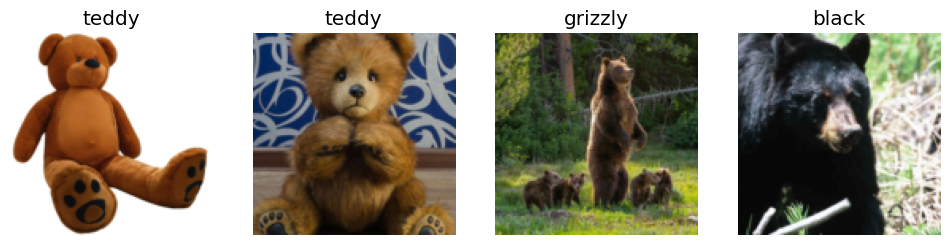

In [20]:
dls.valid.show_batch(max_n=4, nrows=1)

In [22]:
??bears.dataloaders

Signature:
bears.dataloaders(
    source,
    path: 'str' = '.',
    verbose: 'bool' = False,
    *,
    bs: 'int' = 64,
    shuffle: 'bool' = False,
    num_workers: 'int' = None,
    do_setup: 'bool' = True,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    persistent_workers=False,
    pin_memory_device='',
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
) -> 'DataLoaders'
Docstring: Create a `DataLoaders` object from `source`
Source:   
    def dataloaders(self, 
        source, # The data source
        path:str='.', # Data source and default `Learner` path 
        verbose:bool=False, # Show verbose messages
        **kwargs
    ) -> DataLoaders:
        dsets = self.